# Rossmann Store Sales
## Problema de Previsão de Vendas

### Motivação
CFO requisitou essa solução durante uma reunião de resultados mensais;

### Causa Raíz do Problema
Investimento para reforma das lojas;

### Stakeholders
CFO;

### Formato da Solução
Vendas diárias em R$, nos próximos 6 meses;
Problema de predição;
Séries temporais, Regressão e Redes Neurais;
Predições acessadas via celular;

# 0.0 Imports

In [91]:
#Importando bibliotecas
import pandas              as pd
import inflection
import math
import matplotlib.pyplot   as plt
import seaborn             as sns
import numpy               as np

from IPython.core.display  import HTML
from IPython.display       import Image
from datetime              import datetime, timedelta
from tabulate              import tabulate
from scipy                 import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from boruta                import BorutaPy
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

## 0.1 Helper Functions

In [87]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
jupyter_settings()

def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2_corr = max(0, (chi2-((k-1)*(r-1))/(n-1)))
    k_corr = k - ((k-1)**2)/(n-1)
    r_corr = r - ((r-1)**2)/(n-1)
    v = sqrt((chi2_corr/n)/min(k_corr-1,r_corr-1))
    
    return v

def ml_error( model_name, y, yhat):
    mae= mean_absolute_error(y, yhat)
    mape= mean_absolute_percentage_error(y, yhat)
    rmse= sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame( { 'Model Name': model_name,
                         'MAE':mae,
                         'MAPE':mape,
                         'RMSE':rmse}, index=[0])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\berg_\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['grid', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading Data

In [3]:
#Carregando dados
df_sales_raw = pd.read_csv('train.csv', low_memory = False)
df_store_raw = pd.read_csv('store.csv', low_memory = False)

In [4]:
#Verificando os dados
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
#Verificando os dados
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 Descrição dos dados

In [7]:
#criando cópia do dataframe inicial
df1 = df_raw.copy()

## 1.1 Rename Columns 

In [8]:
#renomear colunas para facilitar o trabalho futuro
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

new_cols = list(map(snakecase, old_cols))

df1.columns = new_cols

In [10]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [11]:
#verificando o tamanho do dataframe
print( 'Number of rows: {}' .format (df1.shape[0]) )
print( 'Number of columns: {}' .format (df1.shape[1]) )

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [12]:
#verificando os tipos dos dados
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
#trocando o tipo dos dados
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [14]:
#verificando a existência de NA's nas colunas 
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [15]:
# competition_distance com valores nulos = não há concorrência próxima
## então substituiremos valores nulos com uma distância exageradamente grande
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) 
                                                              else x)

In [16]:
# competition_open_since_month com valores nulos = não sabemos o mês que o concorrente inaugurou ou não temos concorrente
## seguindo o CRISP-DS, inicialmente, para primeira iteração, vamos considerar que é o mesmo mês da venda.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis=1)

In [17]:
# competition_open_since_year com valores nulos = não sabemos o ano que o concorrente inaugurou ou não temos concorrente
## seguindo o CRISP-DS, inicialmente, para primeira iteração, vamos considerar que é o mesmo ano da venda.
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
                                                else x['competition_open_since_year'], axis=1)

In [18]:
#promo2_since_week com valores nulos = a loja não iniciou na promo2
## seguindo o CRISP-DS, inicialmente, para primeira iteração, vamos considerar que é o mesmo mês da venda.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                     else x['promo2_since_week'], axis=1)


In [19]:
#promo2_since_year com valores nulos = a loja não iniciou na promo2
## seguindo o CRISP-DS, inicialmente, para primeira iteração, vamos considerar que é o mesmo ano da venda.
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
                                     else x['promo2_since_year'], axis=1)

In [20]:
#promo_interval com valores nulos = a loja não iniciou na promo2
## seguindo o CRISP-DS, inicialmente, para primeira iteração, vamos criar uma nova coluna para explicitar se é promoção ou não
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'Mai', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1.apply(lambda x: 0 if (x['promo_interval'] == 0) else
                               1 if (x['month_map'] in x['promo_interval'].split(',')) 
                               else 0, axis=1)

In [21]:
#verificando a existência de NA's nas colunas
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Data Types

In [22]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [23]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [24]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

### 1.7.1 Numerical Attributes 

In [25]:
num_attributes = df1.select_dtypes( include=['int64', 'float64', 'int32'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'int32' , 'datetime64[ns]'] )

num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T.reset_index().rename(columns={'index': 'attributes'})

,attributes,mean,median,std,min,max,skew,kurtosis
0,store,558.429727,558.0,321.908651,1.0,1115.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.926175,0.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485759,0.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,-7.235657,124.071304


### 1.7.2 Categorical Attributes 

In [26]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

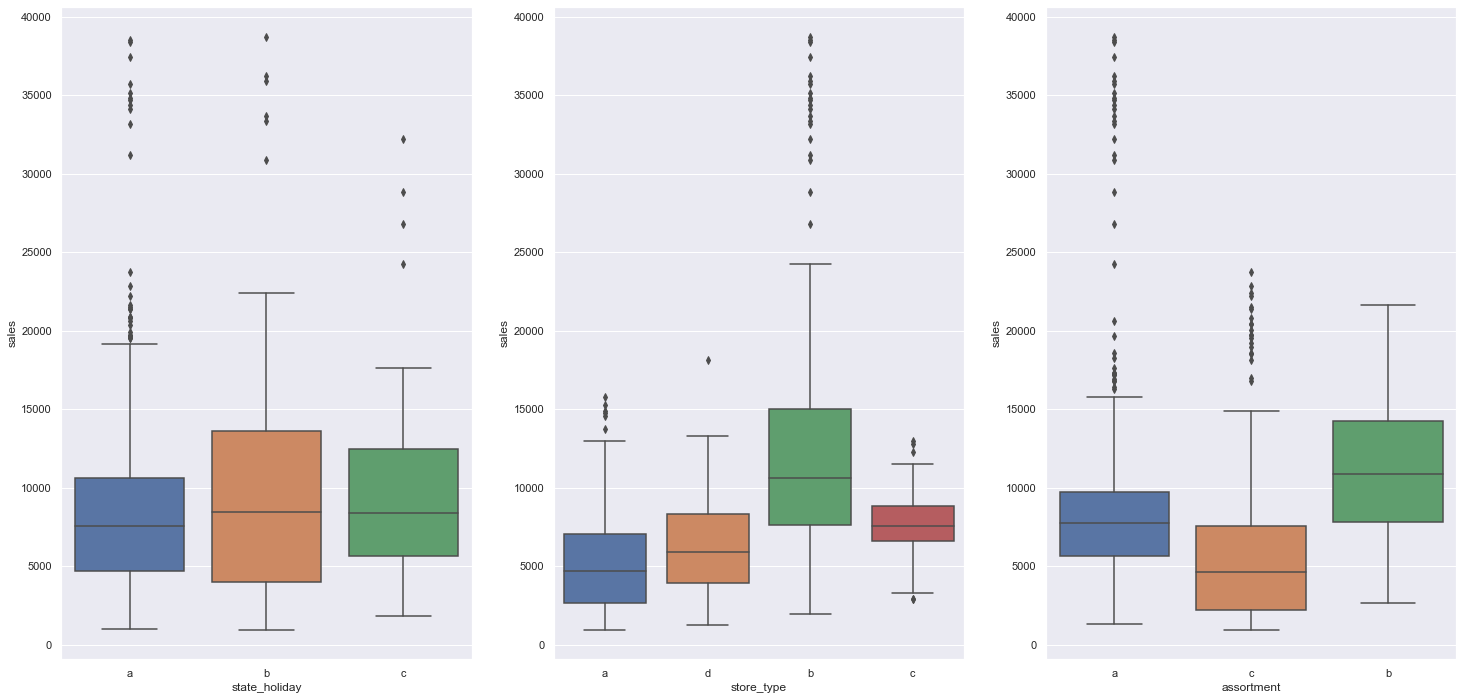

In [27]:
aux = df1[(df1['sales']>0) & (df1['state_holiday']!='0')]

sns.set_style("darkgrid")

fig, ax = plt.subplots(1,3)

sns.boxplot(x='state_holiday', y='sales', data=aux, ax=ax[0])

sns.boxplot(x='store_type', y='sales', data=aux, ax=ax[1])

sns.boxplot(x='assortment', y='sales', data=aux, ax=ax[2])



# 2.0 Feature Engineering

In [28]:
df2 = df1.copy()

In [29]:
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo'],
      dtype='object')

## 2.1 Mapa mental

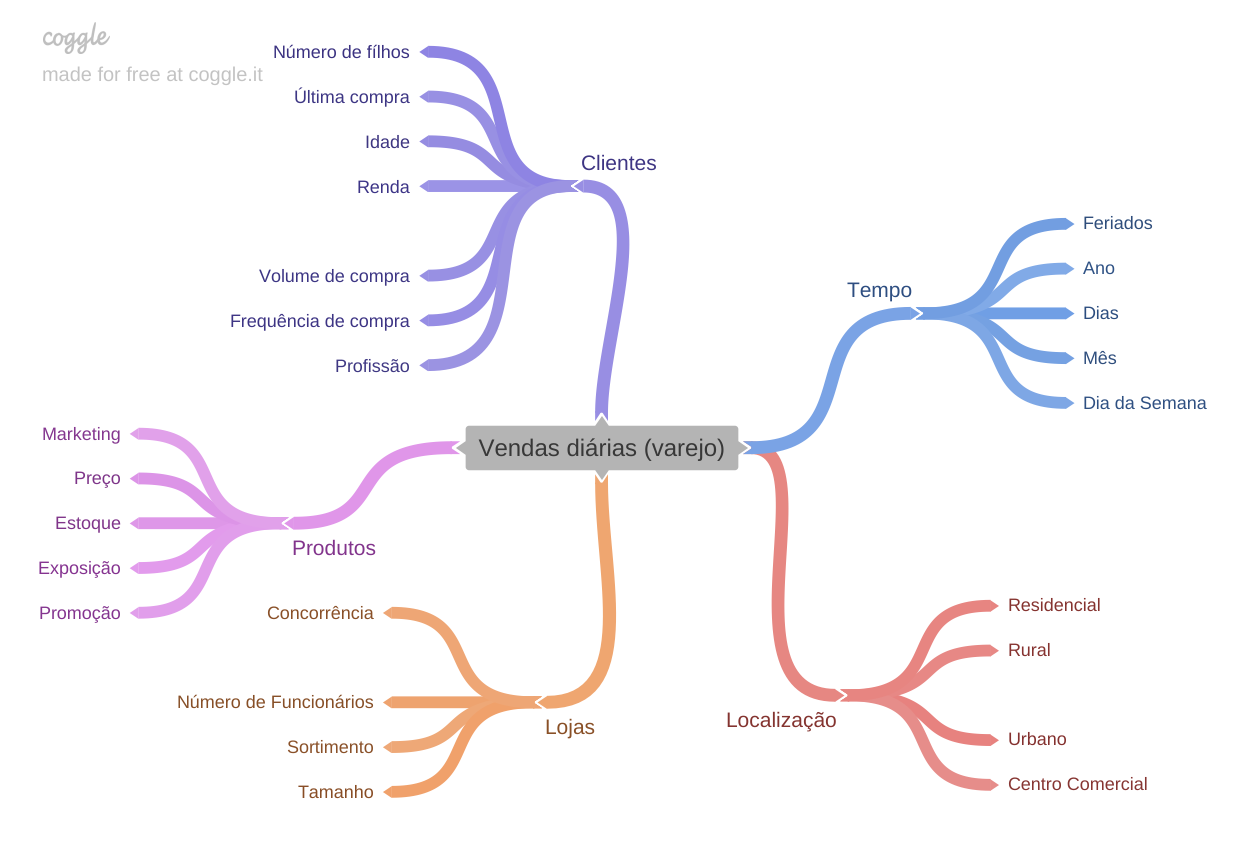

In [30]:
# Mapa mental para representar as vendas diárias no ramo varejista
Image('Vendas_dirias_varejo.png')

## 2.2 Hipóteses

Como não temos informações de Clientes e de Localização, vamos focar em hipóteses geradas por Lojas, Produtos e Tempo.

**1**. Lojas com maior sortimento devem vender mais;

**2**. Lojas com concorrente perto devem vender menos;

**3**. lojas com Concorrentes mais antigos devem vender menos;

**4**. Lojas com promoções ativas por mais tempo devem vender mais;

**5**. Lojas com mais dias de promoção deveriam vender mais;

**6**. Lojas com mais promoções consecutivas deveriam vender mais;

**7**. Lojas abertas no Natal deveriam vender mais;

**8**. Lojas deveriam vender mais ao longo dos anos;

**9**. Lojas deveriam vender mais no segundo semestre do ano;

**10**. Lojas deveriam vender mais depois do dia 10 de cada mês;

**11**. Lojas deveriam vender menos aos finais de semana;

**12**. Lojas deveriam vender menos durante os feriados;

## 2.3 Feature Engineering

In [31]:
#Derivar algumas variáveis

#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week'] = df2['date'].dt.week

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition_since
df2['competition_since'] =df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month = x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days).astype(int)

#promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = (( df2['date']- df2['promo_since'])/7).apply( lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x== 'b' else 'extended')

#state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x== 'b' else 'christmas' if x=='c' else 'regular_day')

C:\Users\berg_\AppData\Local\Temp\ipykernel_3552\218108937.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week'] = df2['date'].dt.week


In [32]:
df2.sample(5).T

,669758,865833,968607,996432,105068
store,429,264,458,408,259
day_of_week,5,4,3,6,2
date,2013-11-08 00:00:00,2013-05-16 00:00:00,2013-02-13 00:00:00,2013-01-19 00:00:00,2015-04-28 00:00:00
sales,6476,8448,5723,5313,13187
customers,535,1078,561,555,2653
open,1,1,1,1,1
promo,1,1,0,0,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0
store_type,d,a,c,c,b


# 3.0 Filtragem de Variáveis

In [33]:
df3 = df2.copy()

In [34]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [35]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 3.1 Filtragem de linhas

In [36]:
#Apenas linhas onde as lojas estejam abertas e apenas onde houve vendas
df3=df3[(df3['open']!=0) & (df3['sales']>0)]

## 3.2 Seleção de colunas

In [37]:
#Excluindo as colunas que não fazem sentido, como colunas construídas anteriormente e colunas redudantes.
df3 = df3.drop(columns=['customers', 'open', 'promo_interval', 'month_map'])

# 4.0 Análise Exploratória de Dados

In [38]:
df4 = df3.copy()

## 4.1 Análise Univariada

Entender o comportamente de cada variável de forma independente;

### 4.1.1 Variável resposta

<AxesSubplot:xlabel='sales', ylabel='Count'>

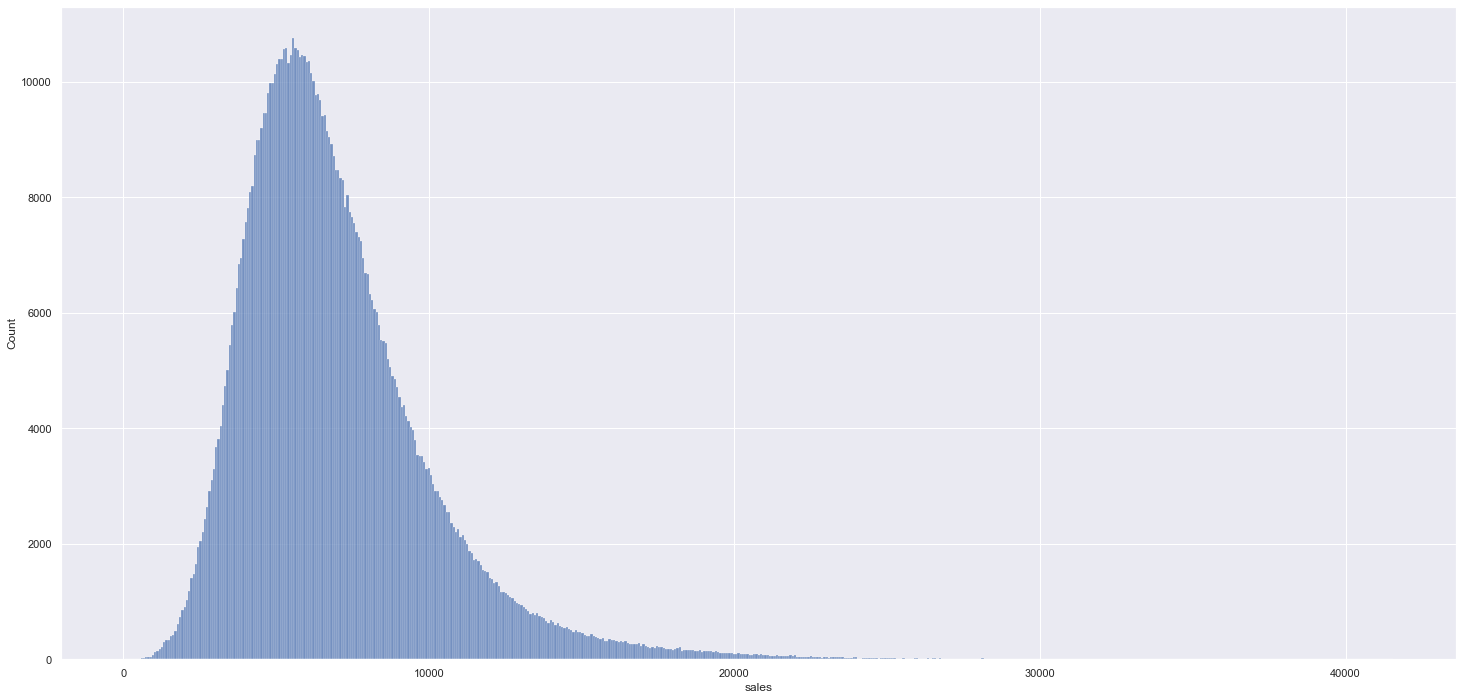

In [39]:
# Construindo um histograma para entender a distribuição da variável resposta:
# - Distribuição assimétrica positiva (moda está concentrada do lado esquerdo da curva)
# - Curtose alta, ou seja, distribuição é mais concentrada e alta do que a distribuição normal (distribuição leptocúrtica)
# - Dados são independentes e possuem uma distribuição próxima à normal.
sns.histplot(data=df4['sales'])

### 4.1.1 Variáveis numéricas

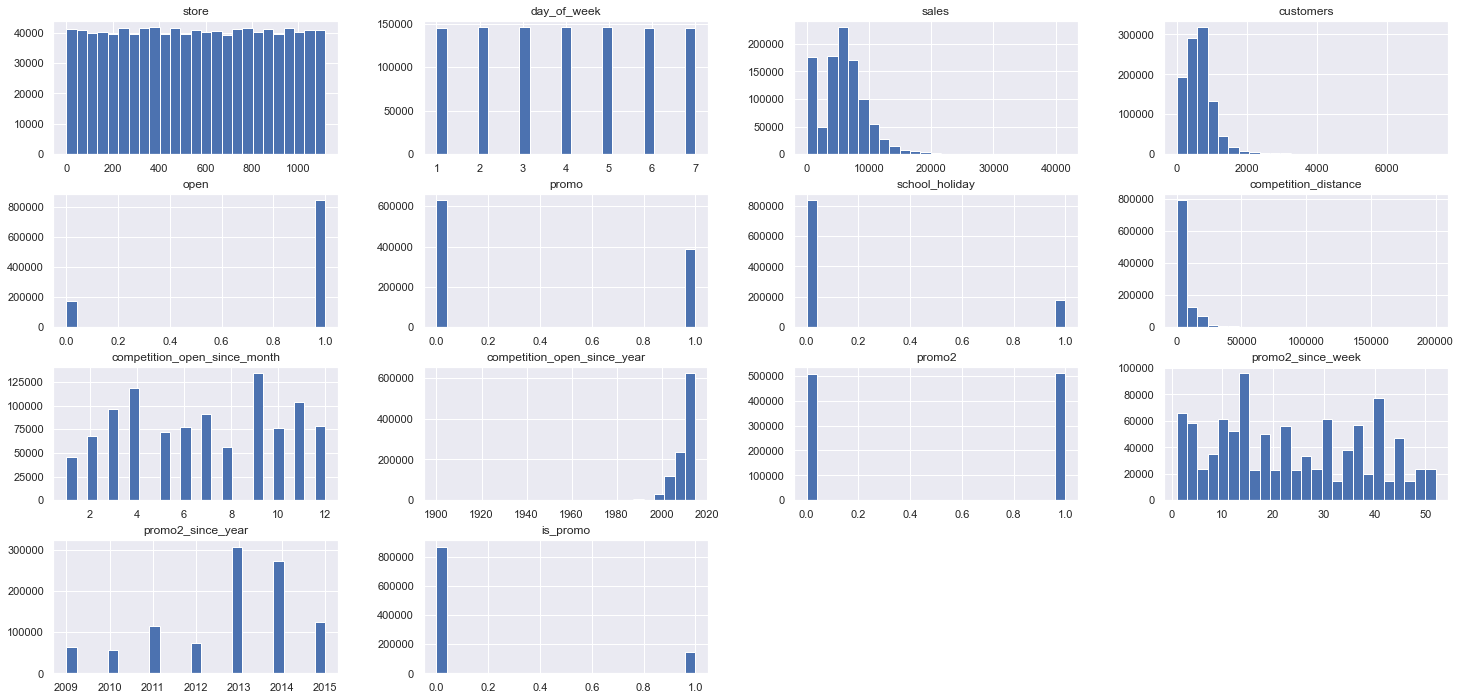

In [40]:
# Construindo histogramas para entender a distribuição das variáveis numéricas:
# - Não há uma relevância na vendas de uma loja separadamente, todas performam de forma parecida;
# - Não há uma relevância nas vendas em relação aos dias da semana, havendo uma performance semelhante em todos os dias;
# - Há consideráveis linhas onde sales é zero, ou seja, loja fechada;
# - Há algumas linhas onde o customers é zero, ou seja, loja fechada; Distribuição assimétrica positiva, com curtose alta;
# - Há mais linhas com loja aberta do que fechada, não representando uma relevância diferenciada para as análises;
# - Há mais vendas quando não temos promoção, basicamente por haver mais dias onde não há promoção;
# - Há mais vendas quando não temos feriados;
# - Temos bastante lojas concorrentes próximos;
# - Conseguimos identificar que há um comportamente de aumento de vendas nos 4 primeiros meses quanto mais antigo é o 
#concorrente, mas que retrai após o quinto mês, havendo um pico no nono mês;
# - Maioria dos concorrentes abribram em 2020;
# - As vendas em relação à promo2 são bem equilibradas, havendo ou não promoção;

num_attributes.hist(bins=25);

### 4.1.1 Variáveis categóricas

In [41]:
cat_attributes.columns

Index(['state_holiday', 'store_type', 'assortment', 'promo_interval',
       'month_map'],
      dtype='object')

In [42]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

<AxesSubplot:xlabel='sales', ylabel='Density'>

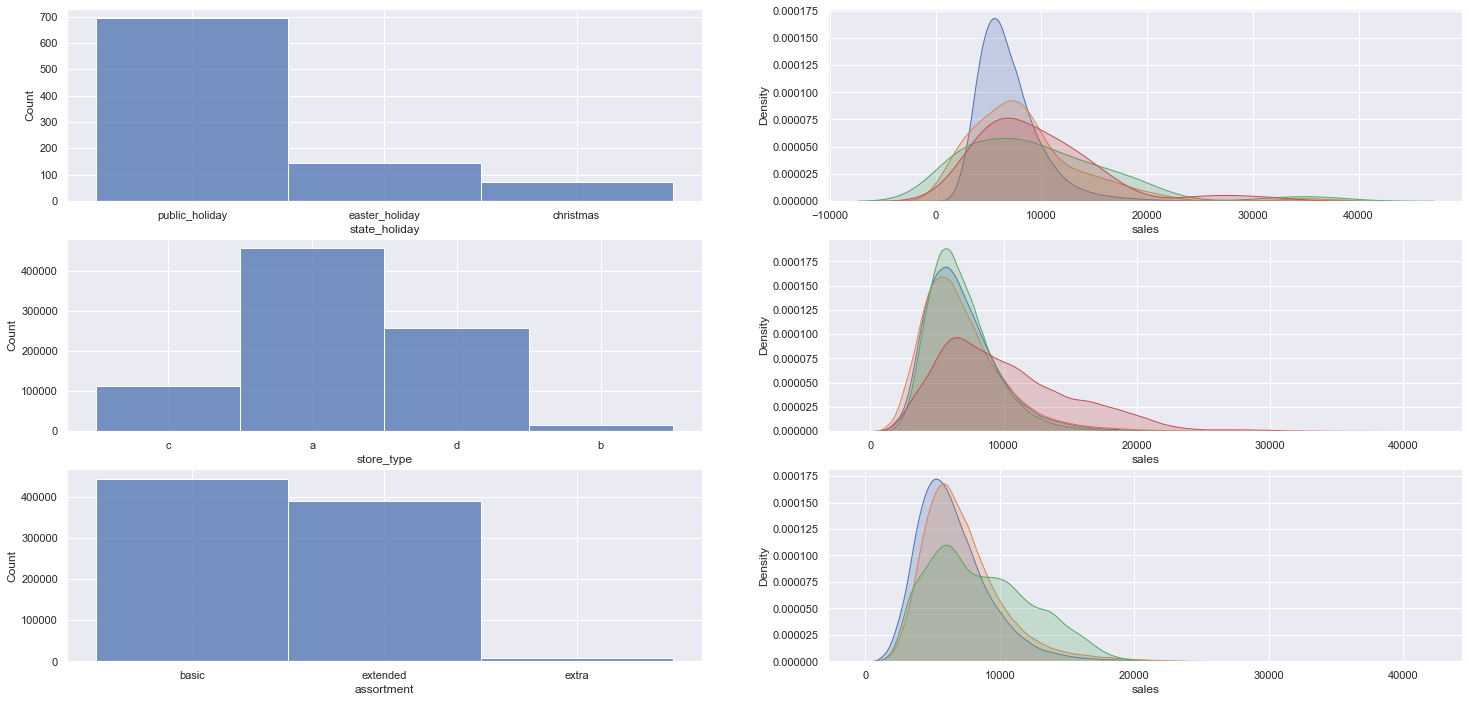

In [43]:
# - Temos mais vendas quando não é feriado, logo, para analisar esse variável, precisamos ignorar os dias regulares;
aux2 = df4[df4['state_holiday'] != 'regular_day'] 

# state_holiday
# - Para variáveis categóricas, vamos construir a Estimativa de Densidade Kernel, além do contagem de linhas, para conseguir
#estimar como seria uma distribuição, considerando cada pico presente no dataset.
ax = plt.subplot(3,2,1)
sns.histplot(x='state_holiday', data=aux2)
ax = plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='regular_day']['sales'], label='regular_day', shade=True)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'], label='public_holiday' , shade=True)
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'], label='easter_holiday' , shade=True)
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'], label='christmas' , shade=True)

# store_type
# - Mudando a dataset para pegar as informações de todos os dias
ax = plt.subplot(3,2,3)
sns.histplot(x='store_type', data=df4)
ax = plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type']=='a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type']=='d']['sales'], label='d', shade=True)
sns.kdeplot(df4[df4['store_type']=='b']['sales'], label='b', shade=True)

# assortment
ax = plt.subplot(3,2,5)
sns.histplot(x='assortment', data=df4)
ax = plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment']=='extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment']=='extra']['sales'], label='extra', shade=True)

# - Mais vendas no feriado do tipo 'public_holiday', apresentando 
# - Mais vendas nas lojas do tipo 'a'
# - Mais vendas do sortimento do tipo 'basic'

## 4.2 Análise Bivariada

Entender o comportamento e correlação entre duas variáveis baseando nas hipóteses traçadas anteriormente:

### 1. Lojas com maior sortimento devem vender mais

**FALSO**, lojas com sortimento 'basic' vendem mais, lojas com sortimento 'extra' vendem menos;

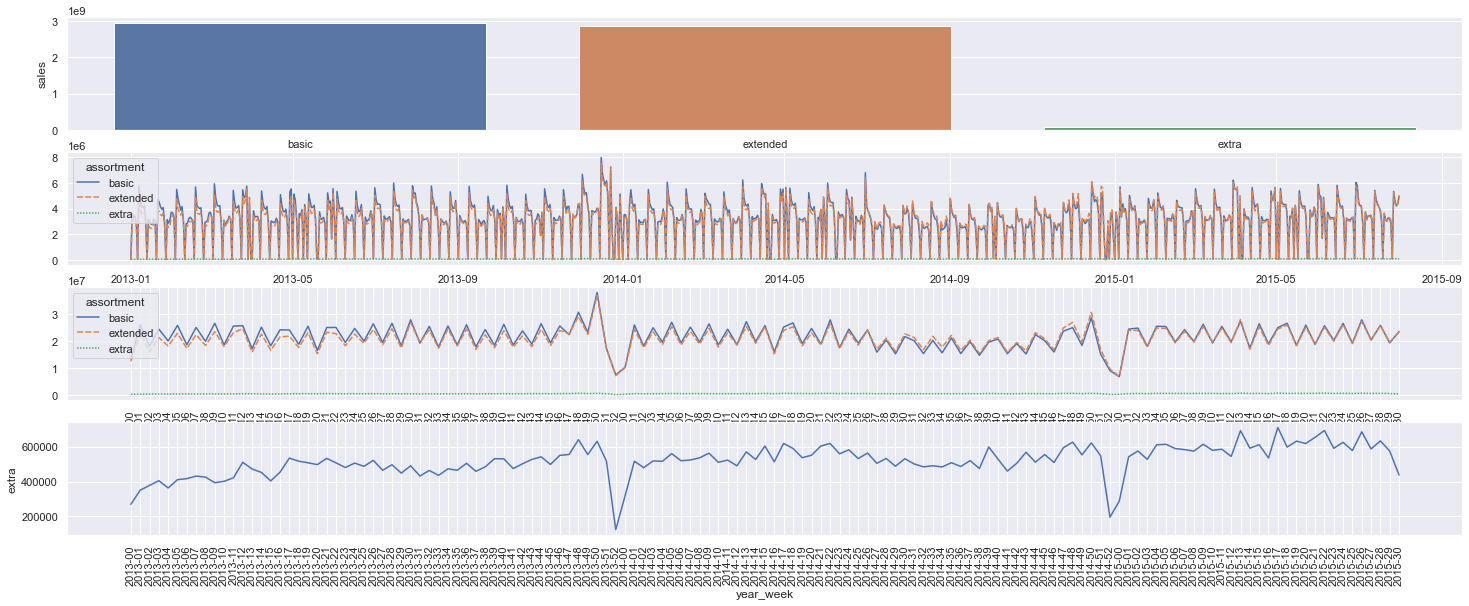

In [44]:
# Visualizando de uma forma geral a quantidade de vendas por tipo de sortimento:
aux1 = df4[['assortment','sales']].groupby(['assortment']).sum().reset_index()
ax = plt.subplot(5,1,1)
sns.barplot(x='assortment', y='sales', data=aux1)

# Traçando o comportamento das variáveis em relação ao tempo:
aux2 = df4[['assortment','sales','date']].groupby(['assortment','date']).sum().reset_index()
aux3 = aux2.pivot(index='date', columns='assortment', values='sales')
ax = plt.subplot(5,1,2)
sns.lineplot(data=aux3)

# Visualização por data fica inviável por haver dias em que a loja não vende. Alterando o tempo para 'year_week':
aux2 = df4[['assortment','sales','year_week']].groupby(['assortment','year_week']).sum().reset_index()
aux3 = aux2.pivot('year_week', 'assortment', 'sales')
ax = plt.subplot(5,1,3)
sns.lineplot(data=aux3)
plt.xticks(rotation=90);

# O Sortimento Extra possui uma performance de vendas muito inferior aos outros, sendo visto, nessa visão, como, praticamente
# uma linha horizontal. Para entender melhor seu comportamento, vamos dar um zoom:
ax = plt.subplot(5,1,4)
aux4 = aux3['extra']
sns.lineplot(data=aux4)
plt.xticks(rotation=90);

# Conseguimos identificar que lojas com sortimento extra possuem vendas que seguem um comportamento semelhante as demais, mas
#magnitude menor;

### 2. Lojas com concorrente perto devem vender menos;

**FALSO**, lojas com concorrência perto vendem mais, lojas com concorrência mais distante vendem menos;

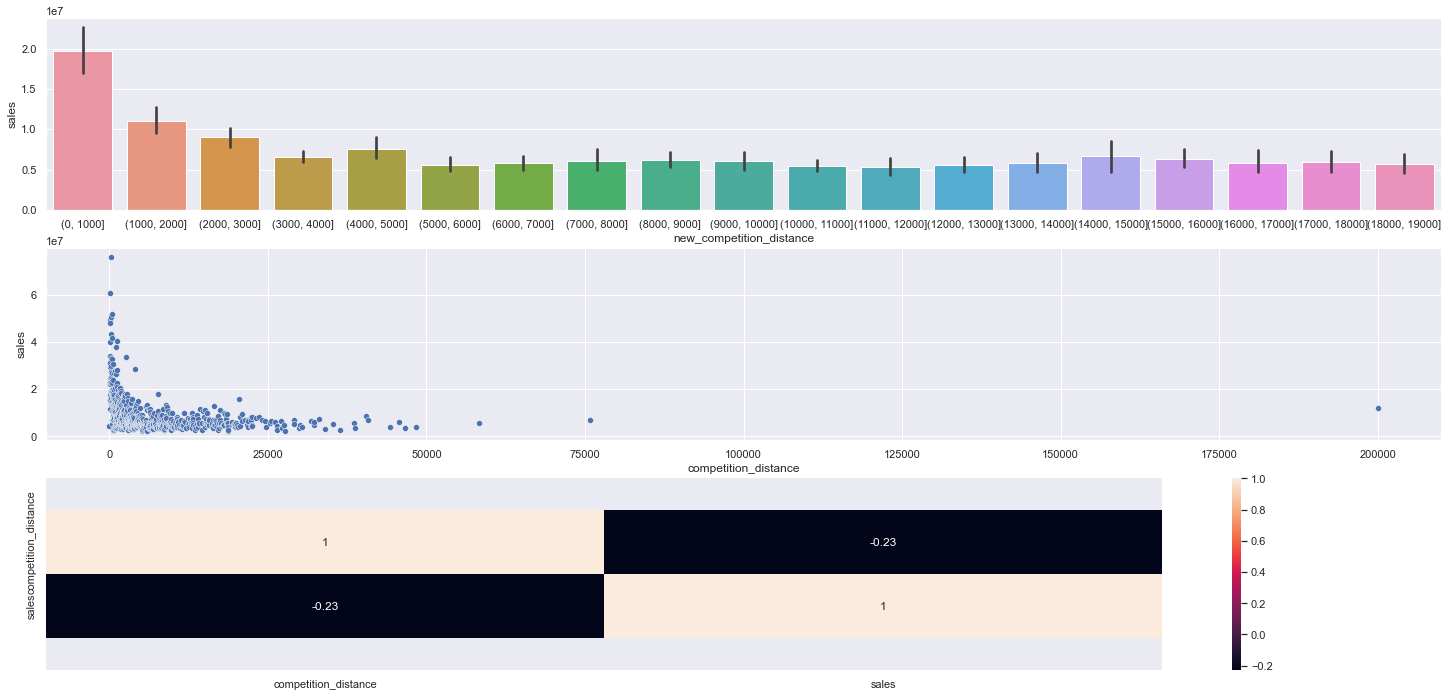

In [45]:
# Plot da distância dos concorrentes em relação as vendas
aux1 = df4[['competition_distance', 'sales']].groupby(['competition_distance']).sum().reset_index()
#ax = plt.subplot(3,1,1)
#sns.barplot(x='competition_distance', y='sales', data=aux1)

# Visualização fica inviável. Dividindo em intervalos:
bins = list(np.arange(0,20000,1000))
aux1['new_competition_distance'] = pd.cut(aux1['competition_distance'], bins=bins)
ax = plt.subplot(3,1,1)
sns.barplot(x='new_competition_distance', y='sales', data=aux1)

# Scatter Plot
ax = plt.subplot(3,1,2)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

# Ou seja, lojas com concorrentes mais próximos tendem a vender mais

ax = plt.subplot(3,1,3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5,top-0.5);

### 3. Lojas com concorrentes mais antigos devem vender menos;

**VERDADEIRO**, inicialmente temos um pico de vendas quando há a inauguração da loja e, ao longo do tempo, há uma diminuição das vendas quando a concorrência se torna mais madura;

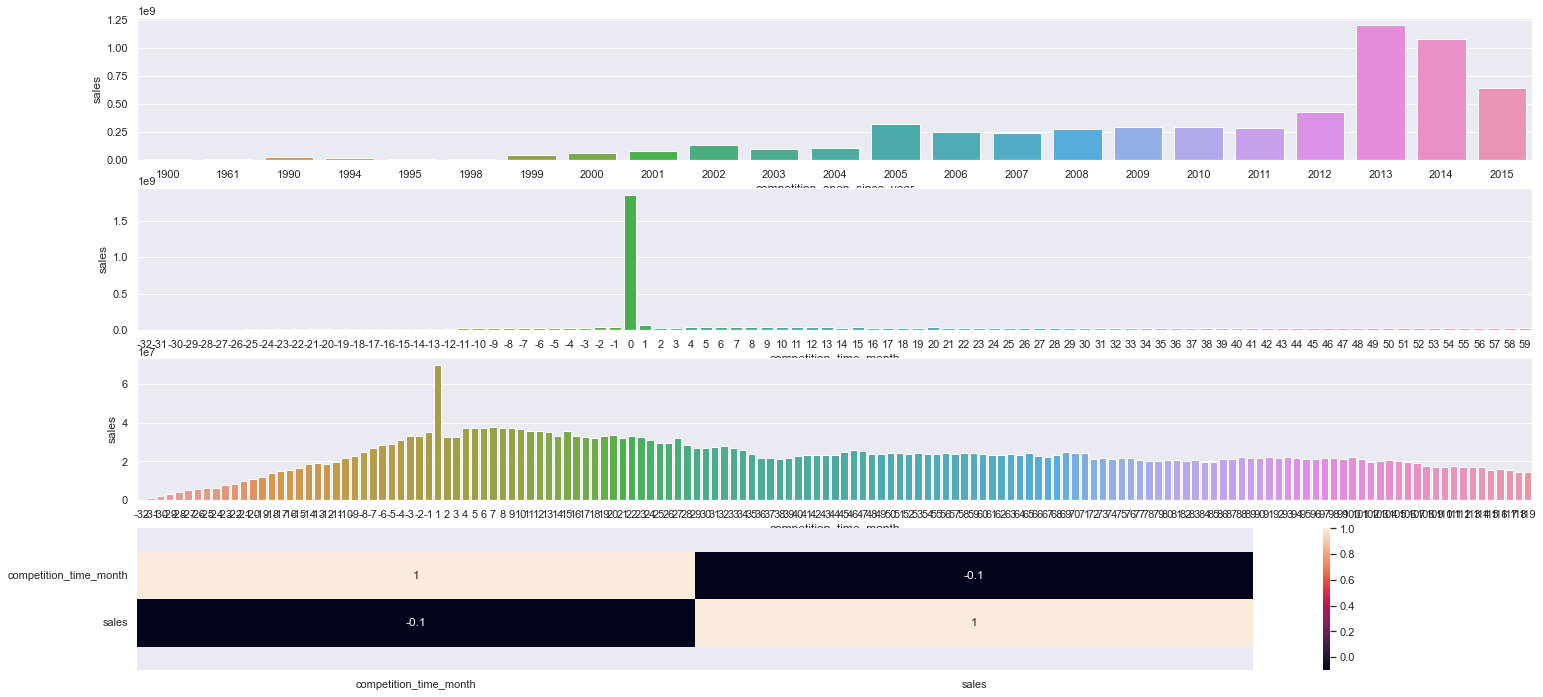

In [46]:
# Verificando as vendas por ano de inauguração do concorrente:
aux1 = df4[['competition_open_since_year', 'sales']].groupby(['competition_open_since_year']).sum().reset_index()
ax = plt.subplot(4,1,1)
sns.barplot(x= 'competition_open_since_year', y = 'sales', data=aux1 )

# Verificando as vendas por tempo de existência do concorrente próximo:
aux2 = df4[['competition_time_month', 'sales']].groupby(['competition_time_month']).sum().reset_index()
# Filtrando vendas feitas apenas nos primeiros 60 meses
aux3 = aux2[(aux2['competition_time_month']<60)]
ax = plt.subplot(4,1,2)
sns.barplot(x= 'competition_time_month', y = 'sales', data=aux3 )

# O maior pico de vendas ocorre nos meses em que as lojas concorrentes foram inauguradas;
# Para entender melhor o comportamento nos outros meses seguintes, vamos ignorar o mês de abertura e olhar os dados de 120 meses
aux4 = aux2[(aux2['competition_time_month']<120)&(aux2['competition_time_month']!=0)]
ax = plt.subplot(4,1,3)
sns.barplot(x= 'competition_time_month', y = 'sales', data=aux4 )

# Ou seja, lojas tendem a vender mais no mês da abertura do concorrente, perdendo venda ao longo do tempo;
ax = plt.subplot(4,1,4)
x = sns.heatmap(aux2.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5,top-0.5);

# Pela correlação, quanto maior o tempo de competição, menores são as vendas;

### 4. Lojas com promoções ativas por mais tempo devem vender mais;

**FALSO**, vende regularmente por um tempo de promoção, mas perde a desempenho em vendas com o passar do tempo

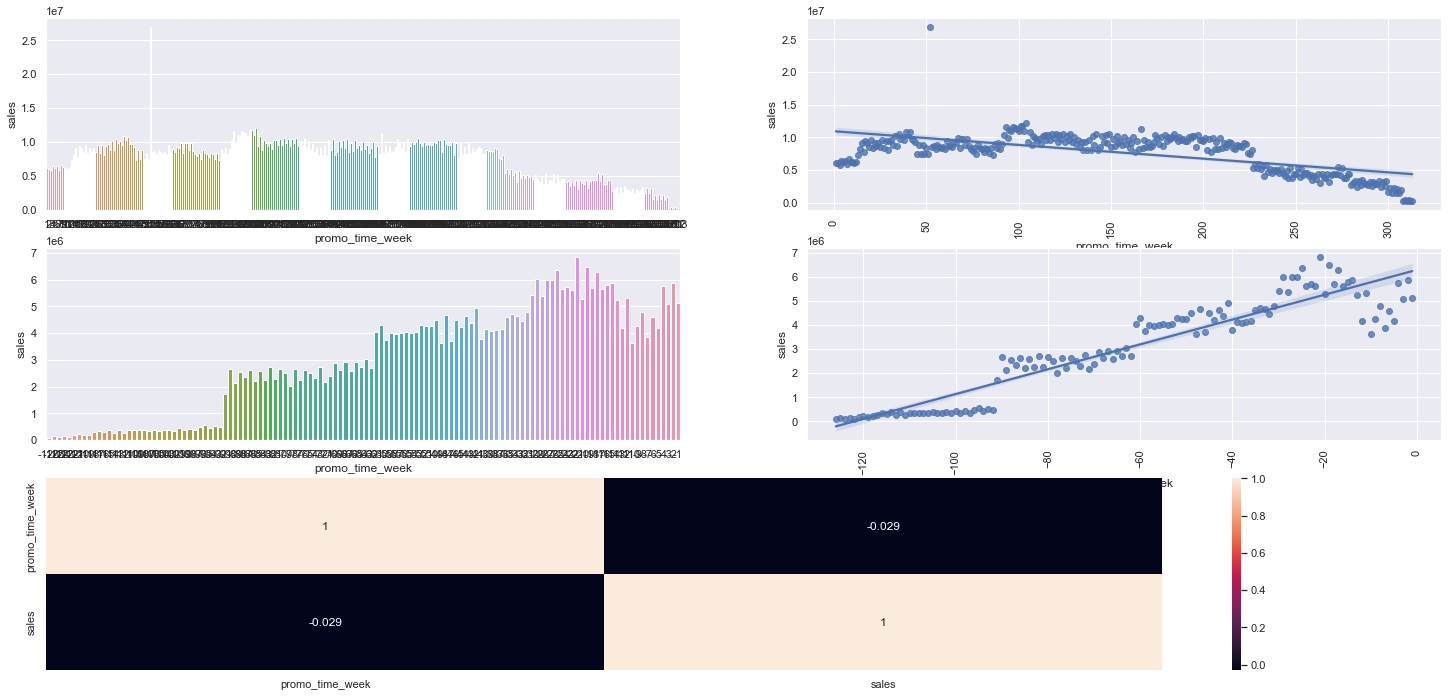

In [47]:
# Vamos verificar o comportamento das vendas com o tempo de promoções em semanas:
aux1 = df4[['promo_time_week','sales']].groupby(['promo_time_week']).sum().reset_index()
#ax = plt.subplot(2,2,1)
#sns.barplot(data=aux1, x= 'promo_time_week', y= 'sales')

grid = GridSpec(3, 2)

# Para melhorar a visualização, vamos dividir o gráfico em duas partes: 'promo_time_week' > 0 e 'promo_time_week'<0
plt.subplot(grid[0,0])
aux2 = aux1[(aux1['promo_time_week']>0)] # Promoção extendido (promo2)
sns.barplot(data=aux2, x= 'promo_time_week', y= 'sales')

plt.subplot(grid[0,1])
sns.regplot(data=aux2, x= 'promo_time_week', y= 'sales')
plt.xticks(rotation=90);

# Se extendermos a promoção demais, começaremos a ter uma queda nas vendas
plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0] # Promoção regular (promo1)
sns.barplot(data=aux3, x= 'promo_time_week', y= 'sales')

plt.subplot(grid[1,1])
sns.regplot(data=aux3, x= 'promo_time_week', y= 'sales')
plt.xticks(rotation=90);
# As vendas começam a aumentar próximo do período promocional, provavelmente impactados por ações de marketing
# Mas após um tempo da promoção extendida, começa a perder vendas;

plt.subplot(grid[2,:])
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)

### <s> 5. Lojas com mais dias de promoção deveriam vender mais; </s>

Dataset não está pronto para essa análise. Adicionarei esse ponto no próximo ciclo do CRISP-DS

### 6. Lojas com mais promoções consecutivas deveriam vender mais;

**FALSO**, Não há um comportamento de aumento de vendas com a extensão de promoções

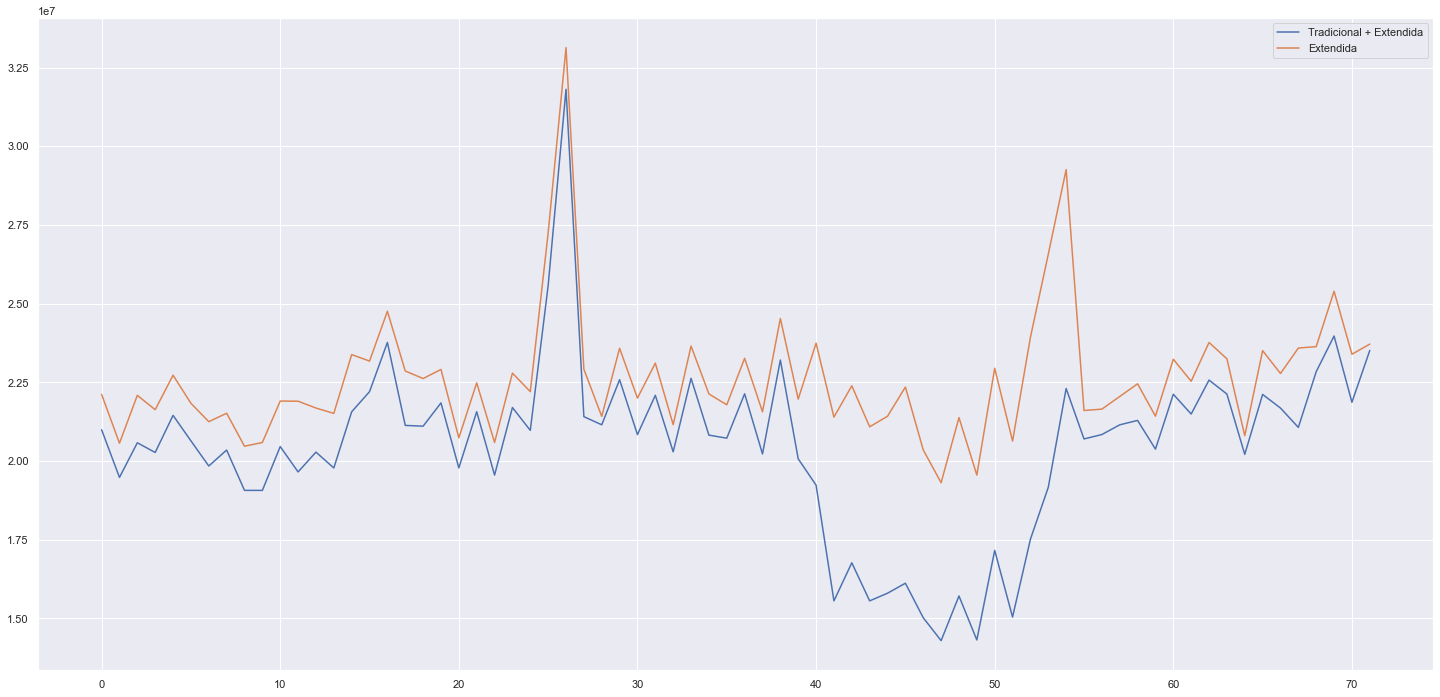

In [48]:
# Entendendo o comportamento das vendas em relação as promoções:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby(['year_week']).sum().reset_index() #Tradicional + Extendida
ax = aux1.plot() 
aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby(['year_week']).sum().reset_index() #Extendida
aux2.plot(ax=ax)
ax.legend(labels=['Tradicional + Extendida', 'Extendida']);
# Não há um desempenho visivel quando se extende as vendas além da tradicional

### 7. Lojas abertas no Natal deveriam vender mais;

**FALSO**, o desempenho em vendas no Natal é o pior quando comparado com os outros feriados;

<AxesSubplot:xlabel='year', ylabel='sales'>

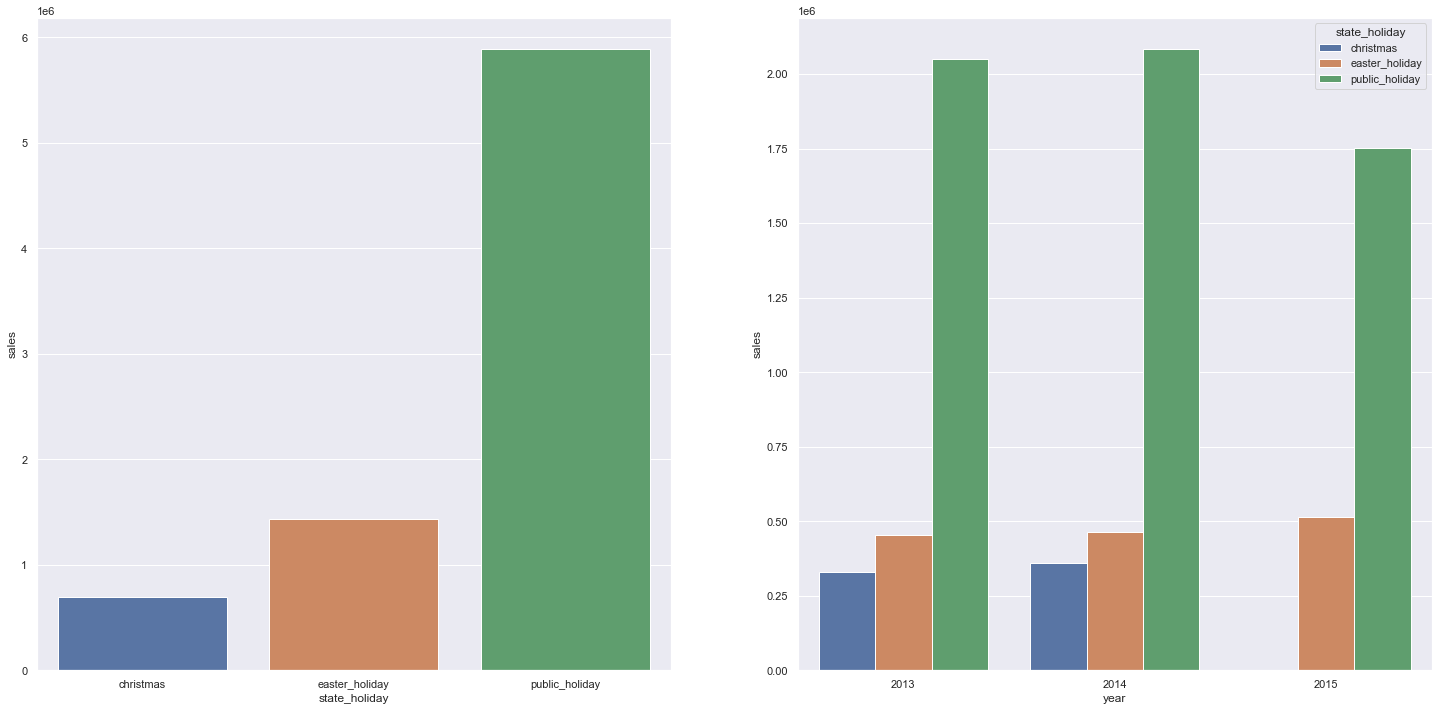

In [49]:
# Verificando as vendas em relação aos feriados (retirando regular_days das análises):
ax = plt.subplot(1,2,1)
aux1 = df4[(df4['state_holiday']!='regular_day')][['state_holiday' , 'sales']].groupby(['state_holiday']).sum().reset_index()
sns.barplot(data=aux1, x='state_holiday', y='sales')

# Historicamente, de forma geral, no Natal as vendas não são maiores do que nos outros feriados.
# Verificando por ano (2015 ainda não temos dados do Natal):
ax = plt.subplot(1,2,2)
aux2 = df4[(df4['state_holiday']!='regular_day')][['state_holiday' , 'sales', 'year']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(data=aux2, x='year', y='sales', hue='state_holiday')

### 8. Lojas deveriam vender mais ao longo dos anos;

**FALSO**, as vendas vêm caindo ao longo dos anos. Quando comparamos por semanas em relação a 2015, conseguimos ver uma melhora considerável, mas é necessário esperar para verificar o ano completo.

<AxesSubplot:>

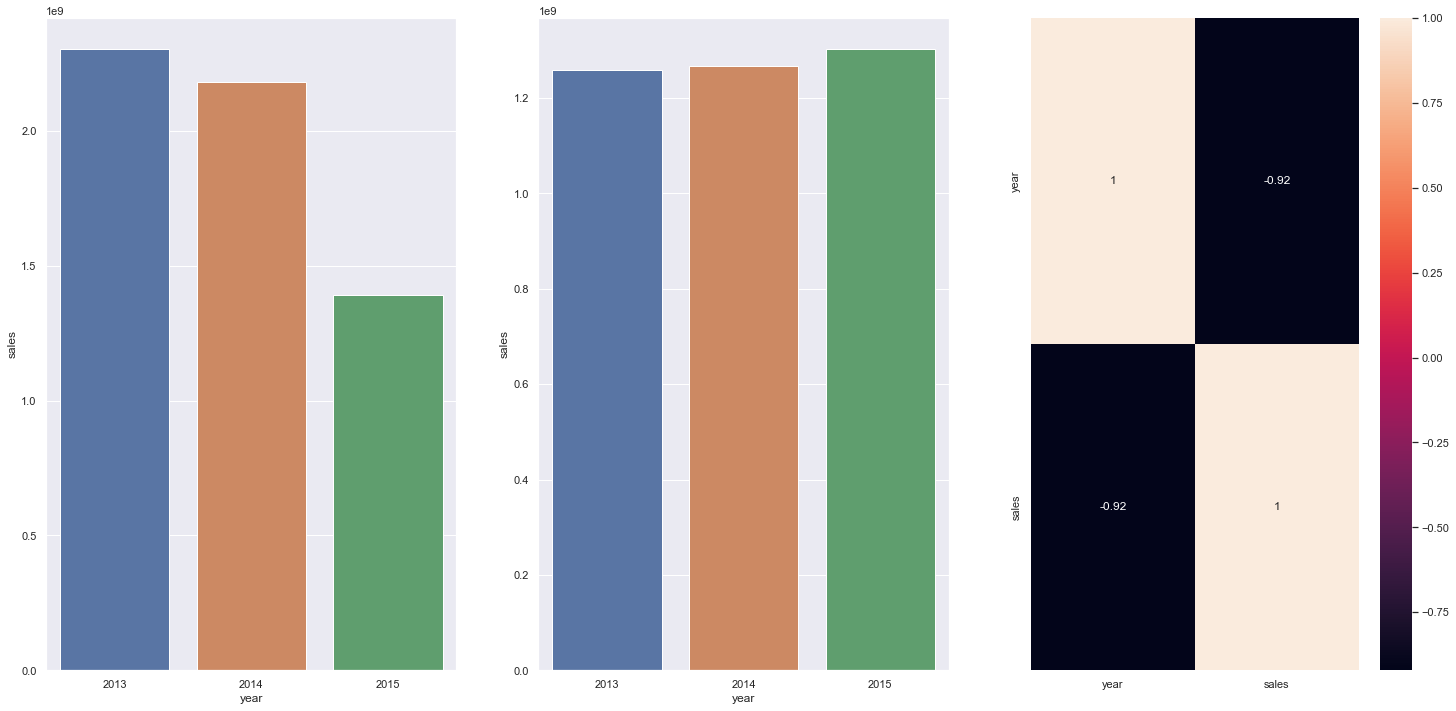

In [50]:
# As vendas vêm caindo quando comparamos 2013 e 2014 (não temos todos os dados do ano de 2015)
ax = subplot(1,3,1)
aux1 = df4[['year','sales']].groupby(['year']).sum().reset_index()
sns.barplot(data=aux1, x='year', y='sales')

# Comparando o desempenho das vendas proporcionalmente ao tempo de 2015 (até a semana 30)
ax = subplot(1,3,2)
aux2 = df4[(df4['week']<30)][['year','sales']].groupby(['year']).sum().reset_index()
sns.barplot(data=aux2, x='year', y='sales')

# Correlação negativa: quanto maior o ano, menor as vendas (muito impactado pelo ano de 2015 estar incompleto)
ax = subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### 9. Lojas deveriam vender mais no segundo semestre do ano;

**FALSO**, historicamente as lojas vendem mais no primeiro semestre, havendo um pico nas vendas de dezembro.

<AxesSubplot:>

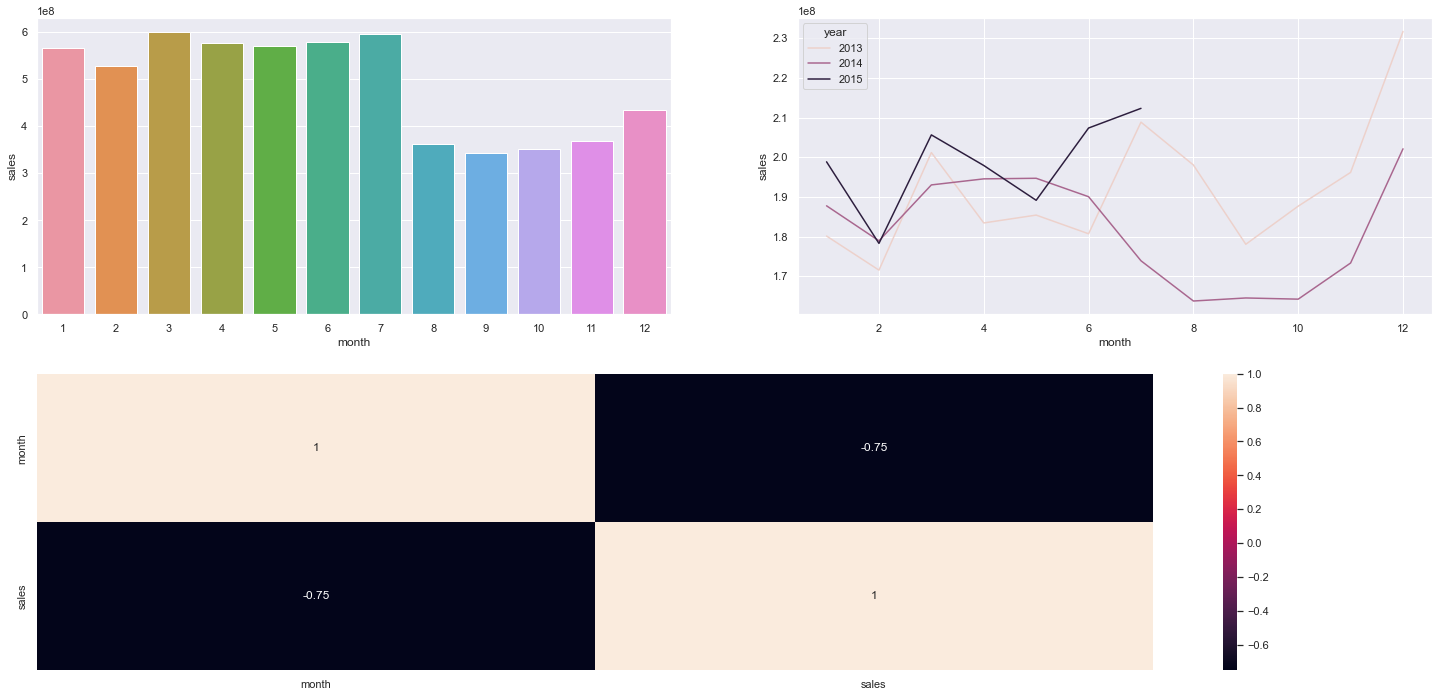

In [51]:
grid = GridSpec(2, 2)
# As vendas vêm caindo do primeiro para o segundo semestre quando olhamos o montante de vendas
ax = subplot(grid[0,0])
aux1 = df4[['month','sales']].groupby(['month']).sum().reset_index()
sns.barplot(data=aux1, x='month', y='sales')

# Comparando o desempenho das vendas em relação ao ano
ax = subplot(grid[0,1])
aux2 = df4[['year','month','sales']].groupby(['year', 'month']).sum().reset_index()
sns.lineplot(data=aux2, x='month', y='sales', hue='year')

# Correlação negativa: quanto 'maior o mês', menor as vendas (muito impactado pelo ano de 2015 estar incompleto)
ax = subplot(grid[1,:])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### 10. Lojas deveriam vender mais depois do dia 10 de cada mês;

**Falso**, lojas tendem a vender menos após o dia 10, mostrado pela correlação e pela linha de tendência.

<AxesSubplot:>

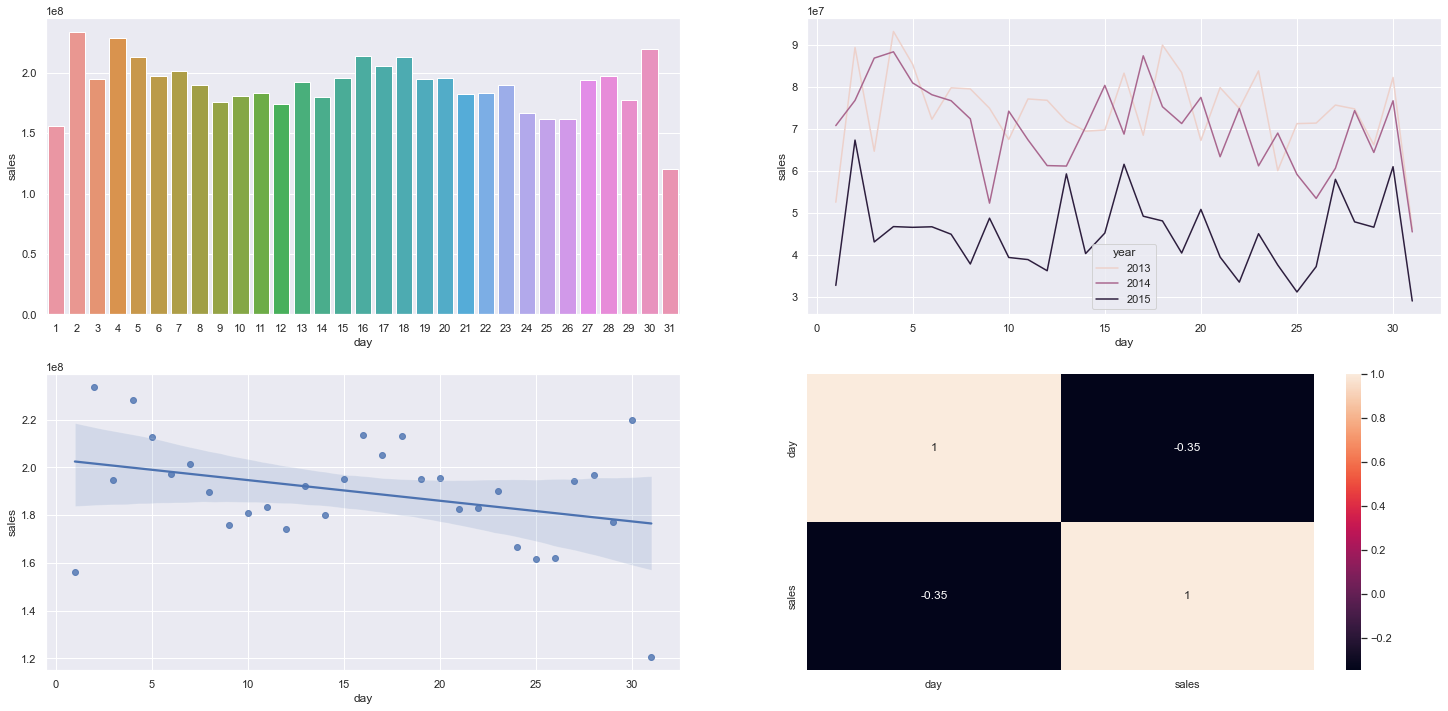

In [52]:
grid = GridSpec(2, 2)
# As vendas vêm caindo após o dia 10 quando olhamos o montante de vendas
ax = subplot(grid[0,0])
aux1 = df4[['day','sales']].groupby(['day']).sum().reset_index()
sns.barplot(data=aux1, x='day', y='sales')

# Comparando o desempenho das vendas em relação aos anos
ax = subplot(grid[0,1])
aux2 = df4[['year','day','sales']].groupby(['year', 'day']).sum().reset_index()
sns.lineplot(data=aux2, x='day', y='sales', hue='year')

# Linha de tendência
ax = subplot(grid[1,0])
sns.regplot(data=aux1, x='day', y='sales')

# Correlação negativa: quanto 'maior o mês', menor as vendas
ax = subplot(grid[1,1])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### 11. Lojas deveriam vender menos aos finais de semana;

**VERDADEIRO**, as vendas acontecem durante a semana, tendo seu maior desempenho na segunda-feira e o pior no domingo;

<AxesSubplot:>

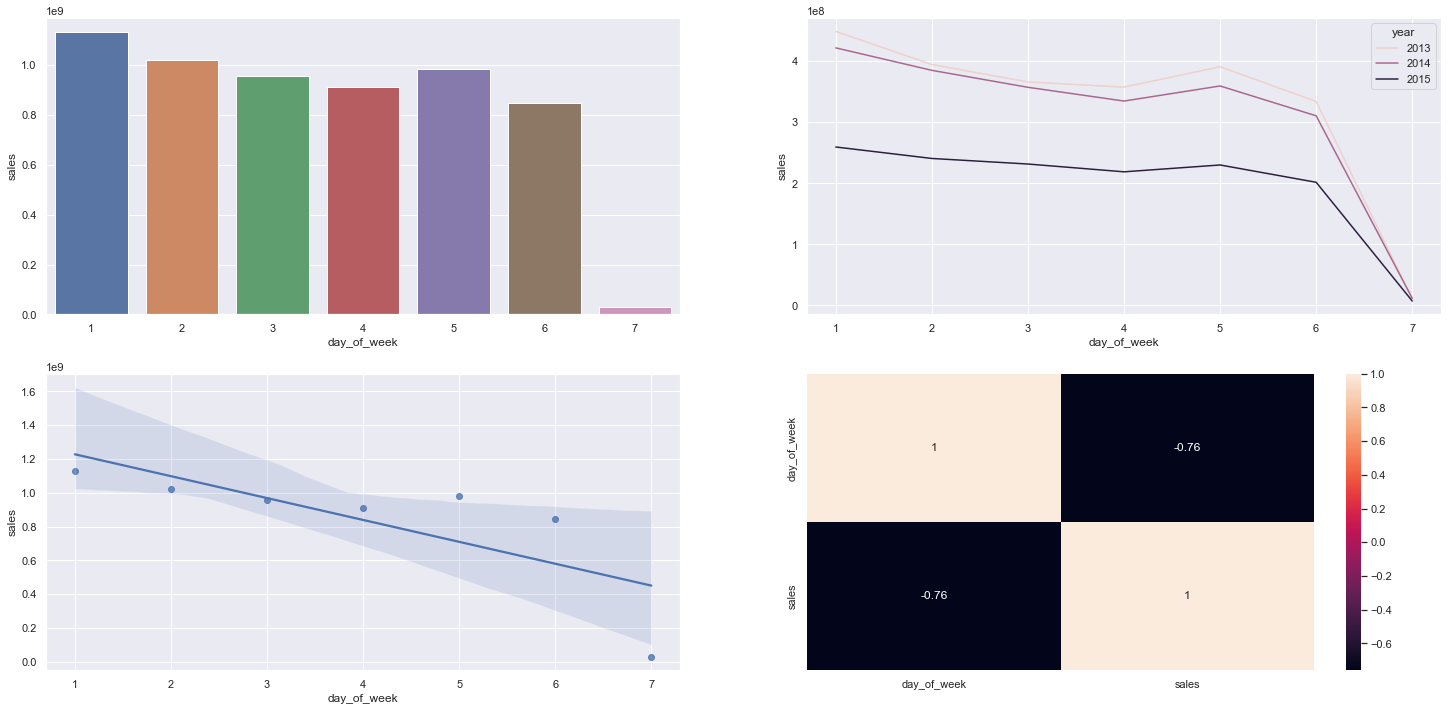

In [53]:
grid = GridSpec(2, 2)
# As vendas acontecem forte durante a semana quando olhamos o montante de vendas
ax = subplot(grid[0,0])
aux1 = df4[['day_of_week','sales']].groupby(['day_of_week']).sum().reset_index()
sns.barplot(data=aux1, x='day_of_week', y='sales')

# Comparando o desempenho das vendas em relação aos anos, percebemos o mesmo padrão
ax = subplot(grid[0,1])
aux2 = df4[['year','day_of_week','sales']].groupby(['year', 'day_of_week']).sum().reset_index()
sns.lineplot(data=aux2, x='day_of_week', y='sales', hue='year')

# Linha de tendência
ax = subplot(grid[1,0])
sns.regplot(data=aux1, x='day_of_week', y='sales')

# Correlação negativa: quanto 'maior o dia da semana', menor as vendas
ax = subplot(grid[1,1])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### 12. Lojas deveriam vender menos durante os feriados escolares;

**VERDADEIRO**, lojas tendem a vender mais fora dos feriados escolares, com excessão dos meses 7 e 8.

<AxesSubplot:xlabel='month', ylabel='sales'>

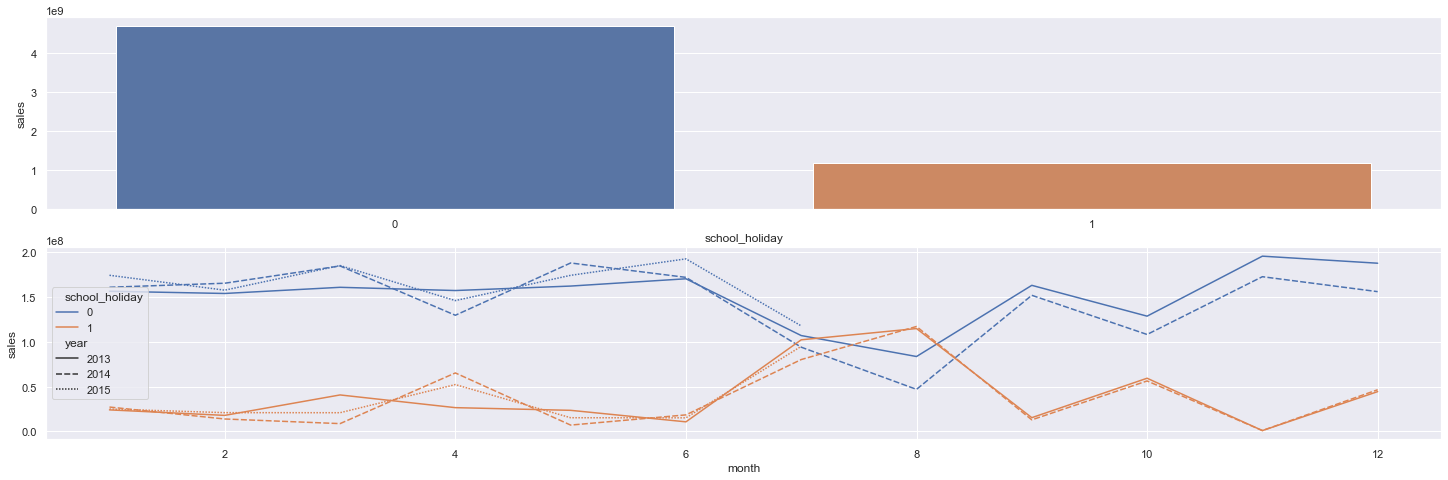

In [54]:
grid = GridSpec(3, 2)
# A quantidade de dias que não são feriados é muito maior, fazendo o volume de vendas ser maior:
ax = subplot(grid[0,:])
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(data=aux1, x = 'school_holiday', y = 'sales')

# Verificando por mês ao longo dos anos
ax = subplot(grid[1,:])
aux2 = df4[['school_holiday', 'sales', 'year', 'month']].groupby(['school_holiday', 'year', 'month']).sum().reset_index()
sns.lineplot(data=aux2, x = 'month', y = 'sales', hue='school_holiday', style='year')

### Resumo da EDA

In [55]:
tab = [['Hipóteses', 'Conclusão', 'Relevância (baseada em insights)'],
      ['H1 - Lojas com maior sortimento devem vender mais', 'Falso', 'Médio'],
      ['H2 - Lojas com concorrente perto devem vender menos', 'Falso', 'Alta'],
      ['H3 - Lojas com concorrentes mais antigos devem vender menos', 'Verdadeiro', 'Alta'],
      ['H4 - Lojas com promoções ativas por mais tempo devem vender mais', 'Falso', 'Alta'],
      ['H5 - Lojas com mais dias de promoção deveriam vender mais', '-', '-'],
      ['H6 - Lojas com mais promoções consecutivas deveriam vender mais', 'Falso', 'Média'],
      ['H7 - Lojas abertas no Natal deveriam vender mais', 'Falso', 'Média'],
      ['H8 - Lojas deveriam vender mais ao longo dos anos', 'Falso', 'Baixa'],
      ['H9 - Lojas deveriam vender mais no segundo semestre do ano', 'Falso', 'Baixa'],
      ['H10 - Lojas deveriam vender mais depois do dia 10 de cada mês', 'Falso', 'Baixa'],
      ['H11 - Lojas deveriam vender menos aos finais de semana', 'Verdadeiro', 'Alta'],
      ['H12 - Lojas deveriam vender menos durante os feriados escolares', 'Verdadeiro', 'Média']
      ]
print(tabulate(tab, headers = 'firstrow'))

Hipóteses                                                         Conclusão    Relevância (baseada em insights)
----------------------------------------------------------------  -----------  ----------------------------------
H1 - Lojas com maior sortimento devem vender mais                 Falso        Médio
H2 - Lojas com concorrente perto devem vender menos               Falso        Alta
H3 - Lojas com concorrentes mais antigos devem vender menos       Verdadeiro   Alta
H4 - Lojas com promoções ativas por mais tempo devem vender mais  Falso        Alta
H5 - Lojas com mais dias de promoção deveriam vender mais         -            -
H6 - Lojas com mais promoções consecutivas deveriam vender mais   Falso        Média
H7 - Lojas abertas no Natal deveriam vender mais                  Falso        Média
H8 - Lojas deveriam vender mais ao longo dos anos                 Falso        Baixa
H9 - Lojas deveriam vender mais no segundo semestre do ano        Falso        Baixa
H10 - Lojas deve

## 4.3 Análise Multivariada

### 4.3.1 Variáveis Numéricas

<AxesSubplot:>

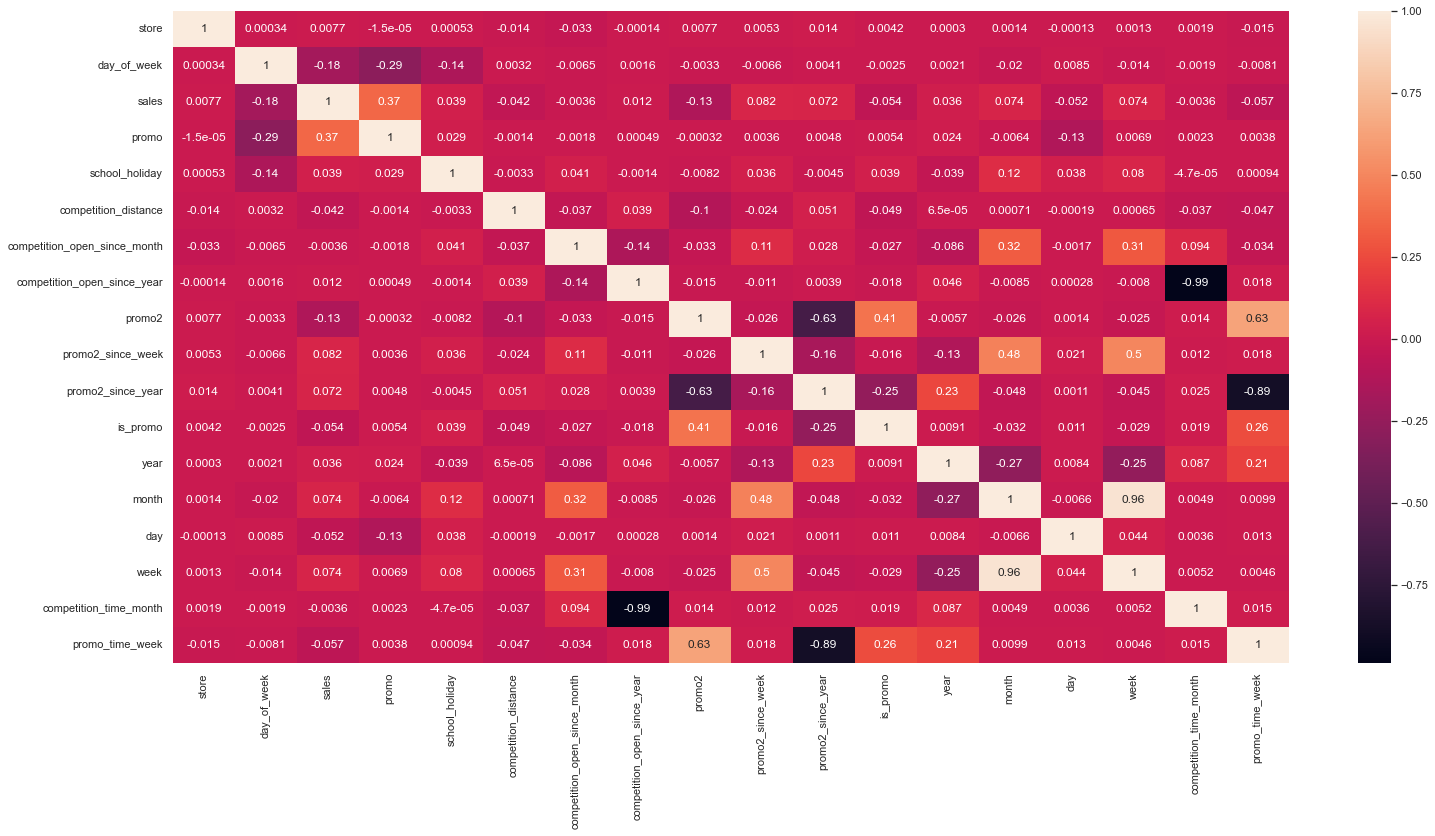

In [56]:
num_attributes = df4.select_dtypes(include = ['int64','float64', 'int32'])
sns.heatmap(num_attributes.corr(method='pearson'), annot=True)

### 4.3.2 Variáveis Categóricas

<AxesSubplot:>

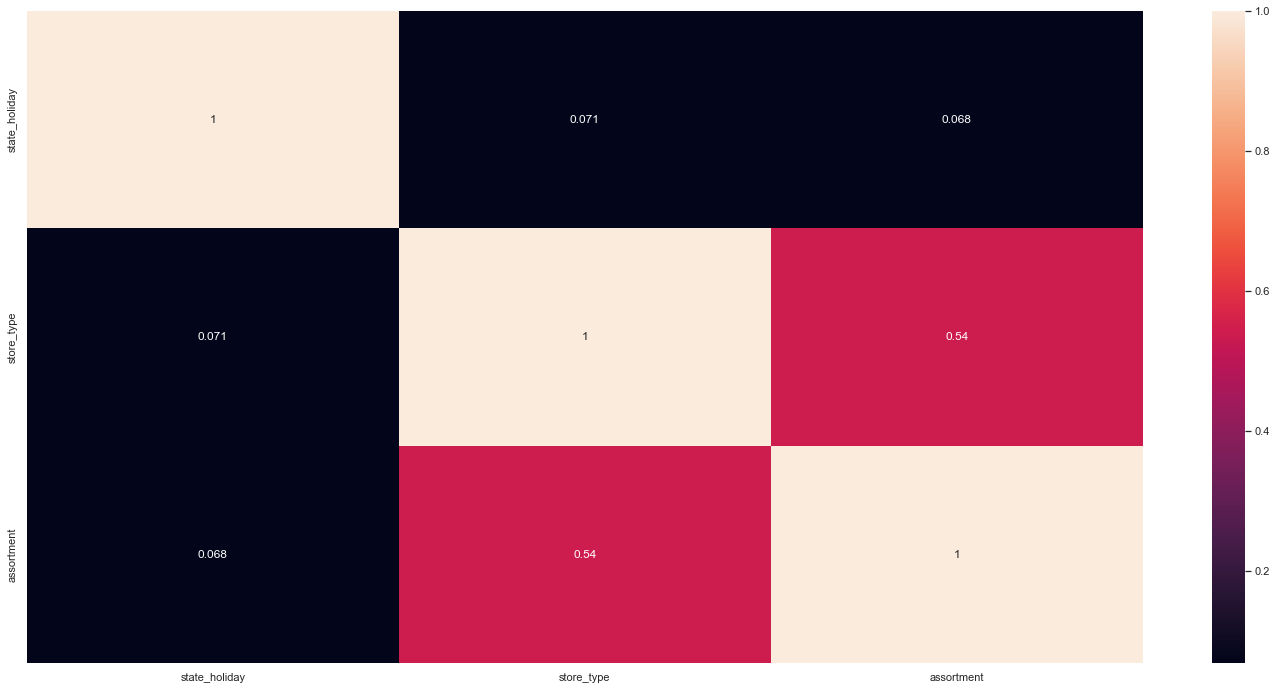

In [57]:
cat = df4.select_dtypes(include=['object'])
cat_list = ['state_holiday', 'store_type', 'assortment']
cat_dic = {}


for c1 in cat_list:
    for c2 in cat_list:
        v = cramer_v(cat[c1], cat[c2])

        if cat_list.index(c2) == 0:
            cat_dic[c1] = []
            cat_dic[c1].append(v)

        else:
            cat_dic[c1].append(v)


cramer_v_table = pd.DataFrame(cat_dic)
cramer_v_table.set_index(cramer_v_table.columns, inplace=True)


sns.heatmap(cramer_v_table, annot=True)

# 5.0 PREPARAÇÃO DE DADOS

In [58]:
# Criando dataset de backup
df5 = df4.copy()
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [59]:
num_variables = df5.select_dtypes( include = ['int64', 'float64', 'int32'])
num_variables.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


## 5.1 Normalização

Não há variáveis numéricas com distribuição puramente gaussiana

## 5.2 Rescaling

C:\Users\berg_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\berg_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\berg_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\berg_\anaconda3\lib\si

<AxesSubplot:xlabel='promo_time_week'>

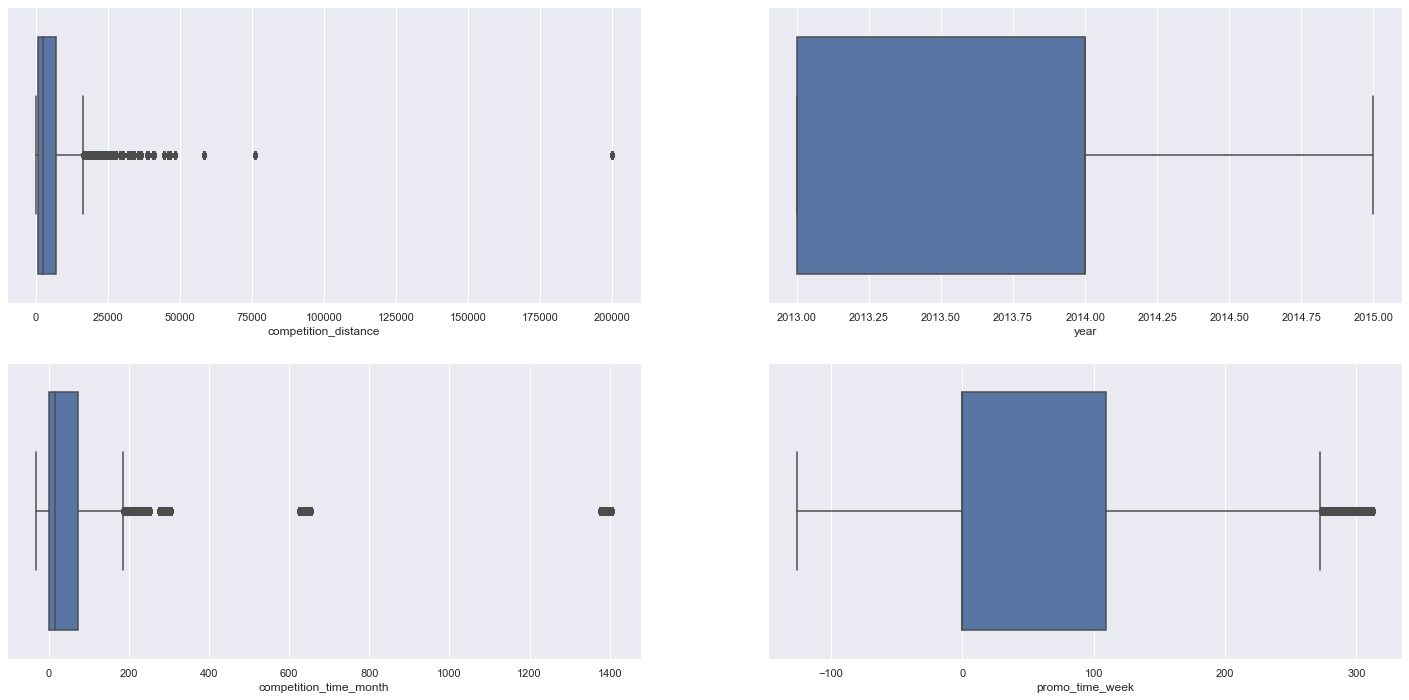

In [60]:
# competition_distance
ax = subplot(2,2,1)
sns.boxplot(num_variables['competition_distance'])

# year
ax = subplot(2,2,2)
sns.boxplot(num_variables['year'])

# competition_time_month
ax = subplot(2,2,3)
sns.boxplot(num_variables['competition_time_month'])

# promo_time_week
ax = subplot(2,2,4)
sns.boxplot(num_variables['promo_time_week'])

# Pela característica dos dados, usaremos Robust Scaler para competition_distance e competition_time_month e Min-Max Scaler para os outros;

### 5.2.1 Robust Scaler

In [61]:
# Preparando dados onde temos muitos outliers
rs = RobustScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

### 5.2.2 Min-Max Scaler

In [62]:
# Preparando dados onde não temos muita influência de outliers
mms = MinMaxScaler()

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

C:\Users\berg_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\berg_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\berg_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\berg_\anaconda3\lib\si

<AxesSubplot:xlabel='promo_time_week'>

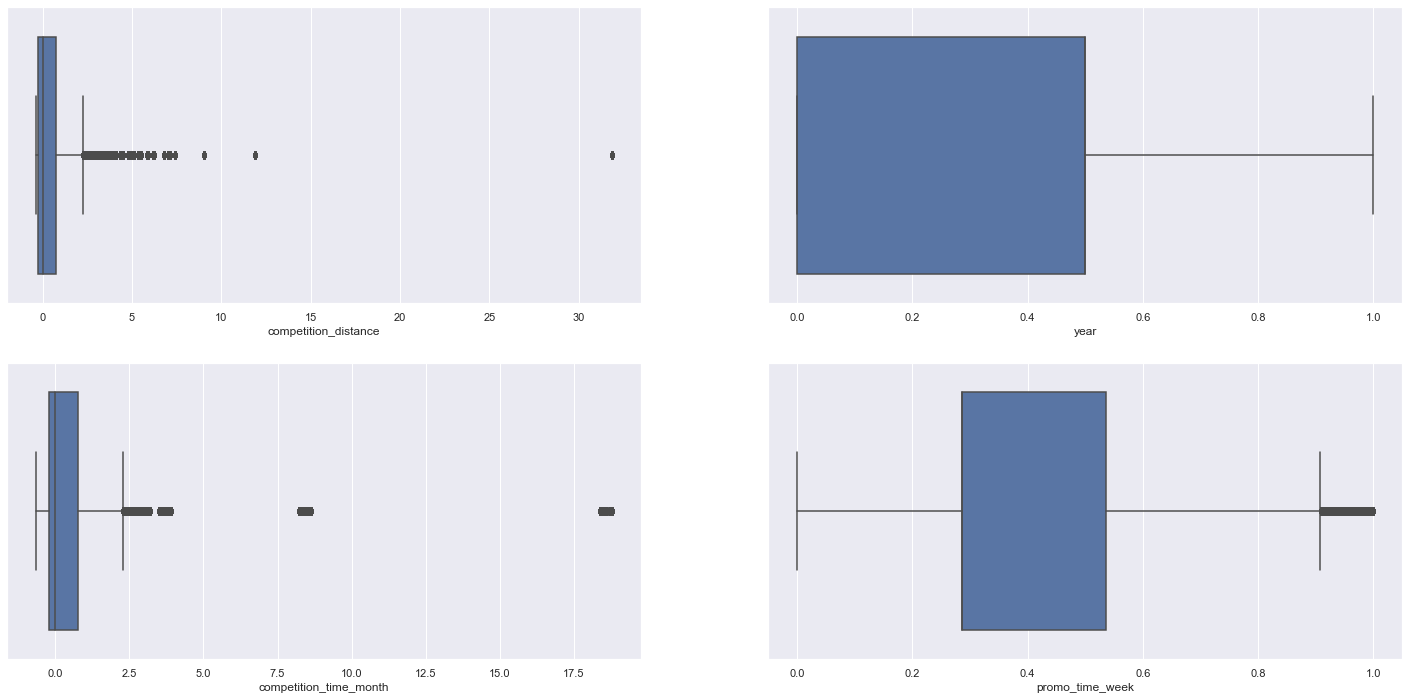

In [63]:
# Como resultado do Rescalling temos: 

num_variables = df5.select_dtypes( include = ['int64', 'float64', 'int32'])

# competition_distance
ax = subplot(2,2,1)
sns.boxplot(num_variables['competition_distance'])

# year
ax = subplot(2,2,2)
sns.boxplot(num_variables['year'])

# competition_time_month
ax = subplot(2,2,3)
sns.boxplot(num_variables['competition_time_month'])

# promo_time_week
ax = subplot(2,2,4)
sns.boxplot(num_variables['promo_time_week'])

## 5.3 Transformação

### 5.3.1 Response Variable Transformation

<AxesSubplot:xlabel='sales', ylabel='Count'>

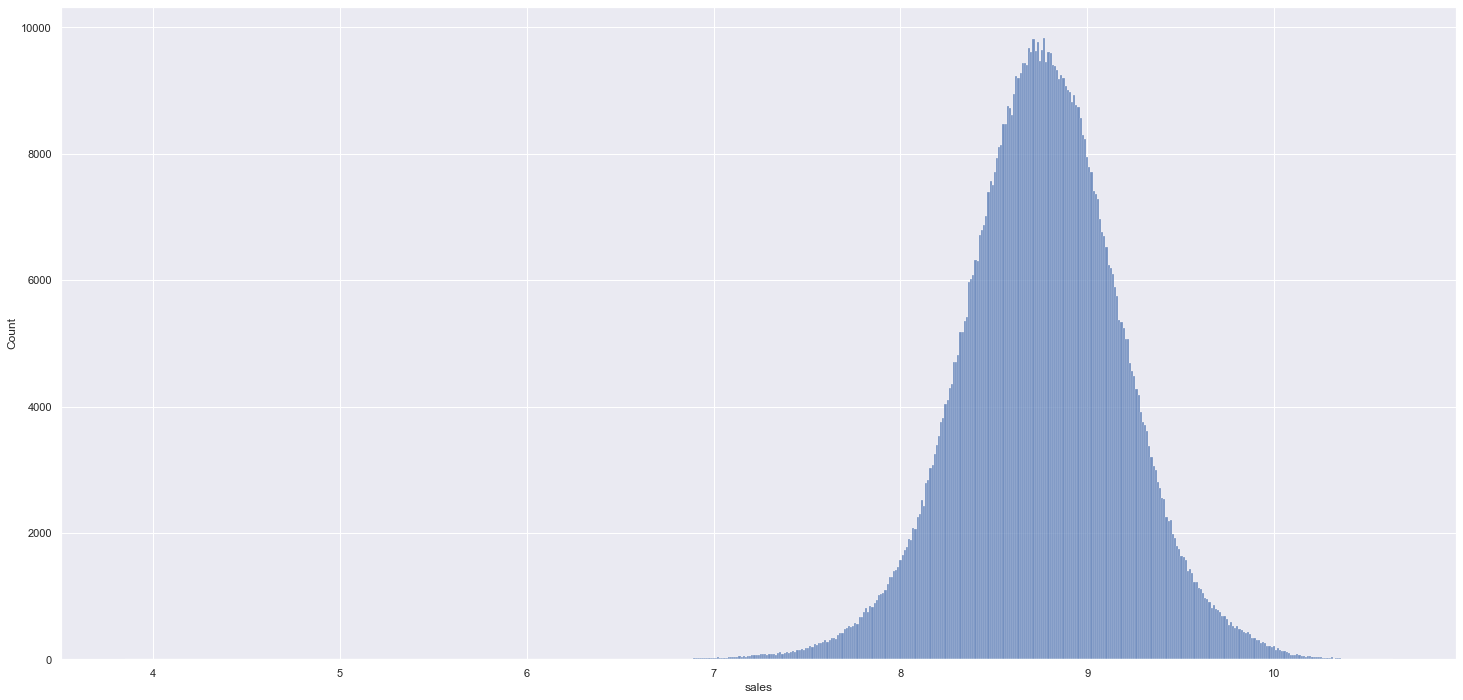

In [64]:
df5['sales'] = np.log1p( df5['sales'] )
sns.histplot(data = df5['sales'])

### 5.3.2 Nature Transformation

In [65]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x*(2*np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x*(2*np.pi/12)))

# week
df5['week_sin'] = df5['week'].apply( lambda x: np.sin( x*(2*np.pi/52)))
df5['week_cos'] = df5['week'].apply( lambda x: np.cos( x*(2*np.pi/52)))

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x*(2*np.pi/31)))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x*(2*np.pi/31)))


In [66]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week,year_week,competition_since,competition_time_month,promo_since,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_sin,week_cos,day_sin,day_cos
0,1,5,2015-07-31,8.568646,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,-2.449294e-16,1.0
1,2,5,2015-07-31,8.710290,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,-2.449294e-16,1.0
2,3,5,2015-07-31,9.025816,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,-2.449294e-16,1.0
3,4,5,2015-07-31,9.546527,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,-2.449294e-16,1.0
4,5,5,2015-07-31,8.481151,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,-2.449294e-16,1.0


### 5.3.3 Encoding

In [67]:
# Preparar dados das variáveis categóricas
cat_variables = df5.select_dtypes( include = ['object'])
cat_attributes.head()

# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - One Hot Encoding
df5 = pd.get_dummies( df5, prefix = ['assortment'], columns=['assortment'])

In [68]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week,year_week,competition_since,competition_time_month,promo_since,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_sin,week_cos,day_sin,day_cos,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,assortment_basic,assortment_extended,assortment_extra
0,1,5,2015-07-31,8.568646,1,1,2,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,-2.449294e-16,1.0,0,0,0,1,1,0,0
1,2,5,2015-07-31,8.710290,1,1,0,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,-2.449294e-16,1.0,0,0,0,1,1,0,0
2,3,5,2015-07-31,9.025816,1,1,0,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,-2.449294e-16,1.0,0,0,0,1,1,0,0
3,4,5,2015-07-31,9.546527,1,1,2,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,-2.449294e-16,1.0,0,0,0,1,0,1,0
4,5,5,2015-07-31,8.481151,1,1,0,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,-2.449294e-16,1.0,0,0,0,1,1,0,0


## 6.0 Seleção de Variáveis

In [69]:
df6 = df5.copy()

### 6.1 Dataset de Treino e Dataset de Teste

In [70]:
df6 = df6.drop(columns=['day', 'week', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week'], axis=1)
df6.head()

,store,date,sales,promo,school_holiday,store_type,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_sin,week_cos,day_sin,day_cos,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,assortment_basic,assortment_extended,assortment_extra
0,1,2015-07-31,8.568646,1,1,2,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,-2.449294e-16,1.0,0,0,0,1,1,0,0
1,2,2015-07-31,8.710290,1,1,0,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,-2.449294e-16,1.0,0,0,0,1,1,0,0
2,3,2015-07-31,9.025816,1,1,0,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,-2.449294e-16,1.0,0,0,0,1,1,0,0
3,4,2015-07-31,9.546527,1,1,2,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,-2.449294e-16,1.0,0,0,0,1,0,1,0
4,5,2015-07-31,8.481151,1,1,0,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,-2.449294e-16,1.0,0,0,0,1,1,0,0


In [71]:
# Tamanho do data set:
# Primeiro dia de vendas:
print( 'Data de início do dataset de treinos: {}'.format(df6[['store', 'date']].groupby('store').min().reset_index()['date'][0] ))

print( 'Data de término do dataset de treino: {}'.format(df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - timedelta(days=((7*7)+1) )))



# Data de início do dataset de teste '2015-06-12';
print( '\nData de início do dataset de teste: {}'.format(df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - timedelta(days=7*7) ))
# Data de término do dataset de teste (7 semanas):
print( 'Data de término do dataset de teste (7 semanas): {}'.format(df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] )) 

Data de início do dataset de treinos: 2013-01-02 00:00:00
Data de término do dataset de treino: 2015-06-11 00:00:00

Data de início do dataset de teste: 2015-06-12 00:00:00
Data de término do dataset de teste (7 semanas): 2015-07-31 00:00:00


In [72]:
# Dataset de treino
X_train = df6[df6['date']<='2015-06-11']
Y_train = X_train['sales']

# Dataset de teste
X_test = df6[df6['date']>='2015-06-12']
Y_test = X_test['sales']

### 6.2 Seleção de Variáveis com Boruta

In [73]:
# Dataset de Treino e Teste para Boruta
X_train_np = X_train.drop(['date', 'sales'], axis=1).values
Y_train_np = Y_train.values.ravel()

# definindo a RandomForest
rf = RandomForestRegressor(n_jobs=-1)

# deinindo boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_np, Y_train_np)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	11


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	11


#### 6.2.1 Variáveis escolhidas pelo Boruta

In [74]:
cols_selected = boruta.support_.tolist()

# Melhores variáveis
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Variáveis não selecionadas
cols_not_selected_boruta = np.setdiff1d( X_train_fs.columns, cols_selected_boruta)

In [75]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'week_cos',
 'day_sin',
 'day_cos',
 'assortment_basic']

### 6.2.2 Variáveis escolhidas - Boruta + Hipóteses

In [76]:
tab = [['Hipóteses', 'Conclusão', 'Relevância (baseada em insights)', 'Boruta' ],
      ['H1 - Lojas com maior sortimento devem vender mais', 'Falso', 'Médio', 'Média'],
      ['H2 - Lojas com concorrente perto devem vender menos', 'Falso', 'Alta', 'Alta'],
      ['H3 - Lojas com concorrentes mais antigos devem vender menos', 'Verdadeiro', 'Alta', 'Alta'],
      ['H4 - Lojas com promoções ativas por mais tempo devem vender mais', 'Falso', 'Alta', 'Alta'],
      ['H5 - Lojas com mais dias de promoção deveriam vender mais', '-', '-', '-'],
      ['H6 - Lojas com mais promoções consecutivas deveriam vender mais', 'Falso', 'Média', 'Alta'],
      ['H7 - Lojas abertas no Natal deveriam vender mais', 'Falso', 'Média', 'Baixa'],
      ['H8 - Lojas deveriam vender mais ao longo dos anos', 'Falso', 'Baixa', 'Baixa'],
      ['H9 - Lojas deveriam vender mais no segundo semestre do ano', 'Falso', 'Baixa', 'Baixa'],
      ['H10 - Lojas deveriam vender mais depois do dia 10 de cada mês', 'Falso', 'Baixa', 'Baixa'],
      ['H11 - Lojas deveriam vender menos aos finais de semana', 'Verdadeiro', 'Alta', 'Alta'],
      ['H12 - Lojas deveriam vender menos durante os feriados escolares', 'Verdadeiro', 'Média', 'Baixa']
      ]
print(tabulate(tab, headers = 'firstrow'))

Hipóteses                                                         Conclusão    Relevância (baseada em insights)    Boruta
----------------------------------------------------------------  -----------  ----------------------------------  --------
H1 - Lojas com maior sortimento devem vender mais                 Falso        Médio                               Média
H2 - Lojas com concorrente perto devem vender menos               Falso        Alta                                Alta
H3 - Lojas com concorrentes mais antigos devem vender menos       Verdadeiro   Alta                                Alta
H4 - Lojas com promoções ativas por mais tempo devem vender mais  Falso        Alta                                Alta
H5 - Lojas com mais dias de promoção deveriam vender mais         -            -                                   -
H6 - Lojas com mais promoções consecutivas deveriam vender mais   Falso        Média                               Alta
H7 - Lojas abertas no Natal deveriam

In [77]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'week_sin',
    'week_cos',
    'day_sin',
    'day_cos',
    'assortment_basic']

# Colunas para adiconar
#feat_to_add = ['date', 'sales']

# Variáveis finais
#cols_selected_boruta.extend(feat_to_add)
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'week_sin',
 'week_cos',
 'day_sin',
 'day_cos',
 'assortment_basic']

## 7.0 - Machine Learning Modelling

In [78]:
# Vamos testar 5 modelos: 3 modelos simples, lineares, e 2 modelos mais complexos, não-lineares;
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

### 7.1 - Average Model

In [88]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# Predição
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions'] 

# Performance
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1389.919196,0.210216,1868.937498


### 7.2 - Linear Regression Model

In [89]:
#model
lr = LinearRegression().fit(x_train, Y_train)

#predição
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1887.849711,0.290156,2702.297544


### 7.3 - Linear Regression Regularized Model - Lasso

In [94]:
#model
lasso = Lasso(alpha=0.01).fit(x_train, Y_train)

#predição
yhat_lasso = lasso.predict(x_test)

#performance
lasso_result = ml_error('Lasso', np.expm1(Y_test), np.expm1(yhat_lasso))
lasso_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1922.748996,0.2888,2786.107722
